## Fetch technical functions

In [0]:
# Get the technical functions
! wget https://raw.githubusercontent.com/nk-dan/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/nk-dan/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/nk-dan/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/nk-dan/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/nk-dan/mlhep2019_2_phase/raw/master/analysis/generator.py
! wget https://github.com/nk-dan/mlhep2019_2_phase/raw/master/analysis/critic.py

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Fetch the dataset

In [0]:
from google.colab import drive
drive.mount('/gdrive')

# Uncomment if running via google colab
# (you might need to change the paths in this case)
train_data_path = '/gdrive/My Drive/mlhep2019_gan/data_train.npz'
val_data_path = '/gdrive/My Drive/mlhep2019_gan/data_val.npz'
test_data_path = '/gdrive/My Drive/mlhep2019_gan/data_test.npz'

# Uncomment if running locally
#train_data_path = '../data_train.npz'
#val_data_path   = '../data_val.npz'
#test_data_path  = '../data_test.npz'

## Load the data

In [0]:
def dataset_one_particle_type_transform(type_id, EnergyDeposit, ParticleMomentum, ParticlePoint, PDG):
    """
        Select only samples of a particular particle type from data arrays.

        Parameters
        ----------
            type_id : float
                ID of the particle type to be selected.

            EnergyDeposit : torch.Tensor
                Array of energy deposits.
            
            ParticleMomentum : torch.Tensor
                Array of particle momentum.
            
            ParticlePoint : torch.Tensor
                Array of particle coordinates.
            
            PDG : torch.Tensor
                Array of particle types.
            
        Returns:
        ----------
            EnergyDeposit, Momentum, Point, PDG : torch.Tensor x4
                Transformed energy distribution, momentum, coordinate and 
                particle type arrays.
    """
    ind = [i for i, x in enumerate(PDG) if x == type_id]
    return EnergyDeposit[ind], ParticleMomentum[ind], ParticlePoint[ind], PDG[ind]

def get_datasets(data_arr, train_size, valid_size,
                 one_particle_transf=True, particle_id=11.,
                 rotate_transf=False, normalise_energies=False):
    np.random.seed(123)

    energy   = torch.tensor(data_arr['EnergyDeposit'].reshape(-1, 1, 30, 30)).float()
    momentum = torch.tensor(data_arr['ParticleMomentum']).float()
    point    = torch.tensor(data_arr['ParticlePoint'][:, :2]).float()
    pdg      = torch.tensor(data_arr['ParticlePDG']).float()
    data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    if one_particle_transf:
        pdg = data_arr[:][3]
        one_particle_ind_arr = [i for i, x in enumerate(pdg) if x == particle_id]
        energy, momentum, point, pdg = data_arr[one_particle_ind_arr]
        data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    if rotate_transf:
        data_arr = dataset_rotations_transform(data_arr)
    
    if normalise_energies:
        energy, momentum, point, pdg = data_arr[:]
        # standart scaling
        MEAN_ENERGY_MATRIX = energy.mean(axis=0).reshape(1,30,30)
        STD_ENERGY_MATRIX  = energy.std(axis=0).reshape(1,30,30)
        energy = (energy - MEAN_ENERGY_MATRIX) / STD_ENERGY_MATRIX

        # E \in [E_min, E_max] -> E \in [-1, 1]
        energy = energy / torch.max(energy.abs())
        #print('E_min = ', energy.min())
        #print('E_max = ', energy.max())
        data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    dataset_len = len(data_arr)
    ind_arr = np.random.permutation(dataset_len)
    train_ind_arr = ind_arr[0:train_size]
    valid_ind_arr = ind_arr[train_size:train_size+valid_size]

    energy, momentum, point, pdg = data_arr[train_ind_arr]
    train_dataset = utils.TensorDataset(energy, momentum, point, pdg)

    energy, momentum, point, pdg = data_arr[valid_ind_arr]
    valid_dataset = utils.TensorDataset(energy, momentum, point, pdg)

    # sanity check
    # print(len(np.unique(np.concatenate((train_ind_arr, valid_ind_arr)))))

    return train_dataset, valid_dataset, train_ind_arr, valid_ind_arr

In [0]:
data_train = np.load(train_data_path, allow_pickle=False)

In [0]:
# Normalising stuff

type_id = 11.

ind = [i for i, x in enumerate(data_train['ParticlePDG']) if x == type_id]

mean_train_mom   = np.mean(data_train['ParticleMomentum'][ind], axis=0)
mean_train_point = np.mean(data_train['ParticlePoint'][:,:2][ind], axis=0)

std_train_mom   = np.std(data_train['ParticleMomentum'][ind], axis=0)
std_train_point = np.std(data_train['ParticlePoint'][:,:2][ind], axis=0)

print(mean_train_mom, mean_train_point)
print(std_train_mom, std_train_point)

MEAN_TRAIN_MOM   = np.array([-0.08164814, -0.02489864, 20.8446184])
MEAN_TRAIN_POINT = np.array([-0.01204223,  0.02772552])
STD_TRAIN_MOM    = np.array([ 5.4557047,   5.38253167, 24.26102735])
STD_TRAIN_POINT  = np.array([ 2.69435522,  2.65776869])

[-0.08164814 -0.02489864 20.8446184 ] [-0.01204223  0.02772552]
[ 5.4557047   5.38253167 24.26102735] [2.69435522 2.65776869]


In [0]:
mean_train_energy_pix = np.mean(data_train['EnergyDeposit'][ind])
std_train_energy_pix = np.std(data_train['EnergyDeposit'][ind])

print(mean_train_energy_pix, std_train_energy_pix)

MEAN_TRAIN_ENERGY_PIX = 3.870147771370233
STD_TRAIN_ENERGY_PIX = 25.186363383917545

3.870147771370233 25.186363383917545


## Training GAN
###### ...is not a simple matter
###### so here is some [music for this long process](https://www.youtube.com/watch?v=rdU-BrNTgjg)

In [0]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN', 'HINGE', 'RAHINGE']

TASK = 'HINGE'

# Additional things for Wasserstein GAN
LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01

GRAD_PENALTY = True                # https://arxiv.org/abs/1704.00028
ZERO_CENTERED_GRAD_PENALTY = False   # https://arxiv.org/abs/1705.09367

# Small hack that can speed-up training and improve generalization
INSTANCE_NOISE = False               # https://arxiv.org/abs/1610.04490

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

def l2_norm(tensor):
    """Return the l2 norm of a tensor."""
    return torch.sqrt(1e-8 + torch.sum(tensor**2))

In [0]:
class GANLosses(object):
    def __init__(self, task, device, gp = 'local-two-sided'):
        self.TASK = task
        self.device = device
        self.GP = gp
    
    def g_loss(self,  discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output_gen + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output_gen + eps).mean()
        elif self.TASK in ['WASSERSTEIN', 'HINGE']:
            loss = - discrim_output_gen.mean()
        elif self.TASK == 'RAHINGE':
            loss = ((torch.nn.ReLU()(1.0 + (discrim_output_real - torch.mean(discrim_output_gen)))).mean() + (torch.nn.ReLU()(1.0 - (discrim_output_gen - torch.mean(discrim_output_real)))).mean())/2
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        elif self.TASK == 'HINGE':
            loss = torch.nn.ReLU()(1.0 - discrim_output_real).mean() + torch.nn.ReLU()(1.0 + discrim_output_gen).mean()
        elif self.TASK == 'RAHINGE':
            loss = (torch.mean(torch.nn.ReLU()(1.0 - (discrim_output_real - torch.mean(discrim_output_gen)))) + torch.mean(torch.nn.ReLU()(1.0 + (discrim_output_gen - torch.mean(discrim_output_real)))))/2
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .5):
        gradient_penalty = 0
        k = 1

        if self.GP == 'local-two-sided':
            N = 0.01

            noise_y = torch.normal(0, N, size=inp_data.shape).to(self.device)

            perturbed_y = (inp_data + noise_y).to(self.device)

            perturbed_y.requires_grad = True

            disc_interpolates = discriminator(perturbed_y, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=perturbed_y,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((l2_norm(gradients) - k) ** 2).mean() * lambda_reg

        elif self.GP == 'original':
            alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
            dims_to_add = len(inp_data.size()) - 2
            for i in range(dims_to_add):
                alpha = alpha.unsqueeze(-1)
                # alpha = alpha.expand(inp_data.size())

            interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

            interpolates.requires_grad = True

            disc_interpolates = discriminator(interpolates, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

## Defining generator and discriminator

In [0]:
MEAN_TRAIN_MOM   = np.array([-0.08164814, -0.02489864, 20.8446184])
MEAN_TRAIN_POINT = np.array([-0.01204223,  0.02772552])
STD_TRAIN_MOM    = np.array([ 5.4557047,   5.38253167, 24.26102735])
STD_TRAIN_POINT  = np.array([ 2.69435522,  2.65776869])

MEAN_TRAIN_MOM_POINT = torch.Tensor([-0.08164814, -0.02489864, 20.8446184, -0.01204223,  0.02772552]).to(device)
STD_TRAIN_MOM_POINT  = torch.Tensor([ 5.4557047,   5.38253167, 24.26102735, 2.69435522,  2.65776869]).to(device)

In [0]:
class ConditionalBatchNorm2d(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.num_features = out_features
    self.bn = nn.BatchNorm2d(out_features, affine=False)
    self.gammas = nn.Linear(in_features, out_features)
    self.bethas = nn.Linear(in_features, out_features)
    self._initialize()

  def _initialize(self):
    nn.init.ones_(self.gammas.weight.data)
    nn.init.zeros_(self.bethas.weight.data)

  def forward(self, x, y):
    batchnorm = self.bn(x)
    gamma = self.gammas(y)
    beta = self.bethas(y)
    out = (gamma.view(-1, self.num_features, 1, 1)) * batchnorm + beta.view(-1, self.num_features, 1, 1)
    return out

class SelfAttention(nn.Module):

    def __init__(self, in_dim, activation):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)

    def forward(self,x):

        m_batchsize, C, width, height = x.size()
        proj_query = self.query(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key = self.key(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy = torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out, attention

In [0]:
from torch.nn.utils import spectral_norm

class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        # 30x30x1
        #self.attn0 = SelfAttention(1, 'relu')
        self.conv1 = spectral_norm(nn.Conv2d( 1,   32, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x32
        self.conv2 = spectral_norm(nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(2,2), padding=(1,1))) # 15x15x64       
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = spectral_norm(nn.Conv2d(64, 64, kernel_size=(3,3), stride=(2,2), padding=(1,1)))                                               # 15x15x64
        self.attn1 = SelfAttention(64, 'relu')

        self.conv3 = spectral_norm(nn.Conv2d( 64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x128
        self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1))) # 5x5x256
        
        #self.pool2 = nn.MaxPool2d(3, 3)                                                  # 15x15x256
        #self.conv6 = spectral_norm(nn.Conv2d(256, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1)))
        #self.attn2 = SelfAttention(256, 'relu')
        
        # 5x5x256 = 6400
        self.fc1 = spectral_norm(nn.Linear(6400, 1024))
        #self.fc2 = spectral_norm(nn.Linear(1024,32))
        self.cl = spectral_norm(nn.Linear(5, 1024)) #cgan projection, in original paper: res_block + global_max_pool + linear
        self.fc3 = spectral_norm(nn.Linear(1024,1))
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = EnergyDeposit
        X = F.leaky_relu(self.conv1(X))
        X = F.leaky_relu(self.conv2(X))
        X, _ = self.attn1(X)
        #X = self.pool1(X)

        X = F.leaky_relu(self.conv3(X))
        X = F.leaky_relu(self.conv4(X))
        #X = F.leaky_relu(self.conv5(X))
        #X = F.leaky_relu(self.conv6(X))
        #X, _ = self.attn2(X)
        #X = self.pool2(X)
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #X = torch.cat([X, mom_point], dim=1)
        X = F.leaky_relu(self.fc1(X))
        #X = F.leaky_relu(self.fc2(X))
        #X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        #X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        #X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK in ['WASSERSTEIN', 'HINGE', 'RAHINGE']:
            return self.fc3(X) + torch.sum(self.cl(mom_point) * X, dim=1, keepdim=True)
        else:
            return torch.sigmoid(self.fc1(X))

In [0]:
#not used
class ModelD1(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        # 30x30x1
        self.conv1 = spectral_norm(nn.Conv2d( 1,   16, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x16
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = spectral_norm(nn.Conv2d( 16,  32, kernel_size=(3,3), stride=(1,1), padding=(1,1)))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = spectral_norm(nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(2,2), padding=(1,1))) # 15x15x64  
        self.bn3 = nn.BatchNorm2d(64)    
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = spectral_norm(nn.Conv2d(64, 64, kernel_size=(3,3), stride=(2,2), padding=(1,1)))                                               # 15x15x64
        #self.attn1 = SelfAttention(64, 'relu')
        self.conv4 = spectral_norm(nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x128
        self.bn4 = nn.BatchNorm2d(128)   
        self.conv5 = spectral_norm(nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)))
        self.bn5 = nn.BatchNorm2d(256)    
        self.conv6 = spectral_norm(nn.Conv2d(256, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1))) # 8x8x256
        self.bn6 = nn.BatchNorm2d(256)   
        
        #self.pool2 = nn.MaxPool2d(3, 3)                                                  # 15x15x256
        #self.conv6 = spectral_norm(nn.Conv2d(256, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1)))
        #self.attn2 = SelfAttention(256, 'relu')
        
        # 8x8x256 = 6400
        self.fc1 = spectral_norm(nn.Linear(6400, 2048))
        self.fc2 = spectral_norm(nn.Linear(2048, 1024))
        self.cl = spectral_norm(nn.Linear(5, 1024)) #cgan projection, in original paper: res_block + global_max_pool + linear
        self.fc3 = spectral_norm(nn.Linear(1024, 1))
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = EnergyDeposit
        X = F.leaky_relu(self.bn1(self.conv1(X)))
        X = F.leaky_relu(self.bn2(self.conv2(X)))
        #X = self.pool1(X)

        X = F.leaky_relu(self.bn3(self.conv3(X)))
        X = F.leaky_relu(self.bn4(self.conv4(X)))
        X = F.leaky_relu(self.bn5(self.conv5(X)))
        X = F.leaky_relu(self.bn6(self.conv6(X)))
        #X = F.leaky_relu(self.conv5(X))
        #X = F.leaky_relu(self.conv6(X))
        #X = self.pool2(X)
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #X = torch.cat([X, mom_point], dim=1)
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        #X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        #X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        #X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK in ['WASSERSTEIN', 'HINGE', 'RAHINGE']:
            return self.fc3(X) + torch.sum(self.cl(mom_point) * X, dim=1, keepdim=True)
        else:
            return torch.sigmoid(self.fc1(X))

In [0]:
from generator import NOISE_DIM

class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 20736)

        self.conv1 = spectral_norm(nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1))
        self.bn1 = ConditionalBatchNorm2d(5, 256)
        #self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = spectral_norm(nn.ConvTranspose2d(256, 128, 3))
        #self.bn2 = ConditionalBatchNorm2d(5, 128)
        self.bn2 = nn.BatchNorm2d(128)
        self.attn1 = SelfAttention(128, 'relu')
        self.conv3 = spectral_norm(nn.ConvTranspose2d(128, 64, 3))
        #self.bn3 = ConditionalBatchNorm2d(5, 64)
        self.bn3 = nn.BatchNorm2d(64)
        #self.attn1 = SelfAttention(64, 'relu')
        self.conv4 = spectral_norm(nn.ConvTranspose2d(64, 32, 3))
        self.bn4 = ConditionalBatchNorm2d(5, 32)
        #self.bn4 = nn.BatchNorm2d(32)
        #self.attn2 = SelfAttention(32, 'relu')
        self.conv5 = spectral_norm(nn.ConvTranspose2d(32, 16, 3))
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = spectral_norm(nn.ConvTranspose2d(16, 1, 3))

        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        #x = torch.cat([z, mom_point], dim=1)
        #x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc1(z))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #print(EnergyDeposit.shape)
        EnergyDeposit = F.leaky_relu(self.bn1(self.conv1(EnergyDeposit), mom_point))
        #EnergyDeposit = F.relu(self.bn1(self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposit, _ = self.attn1(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit)))
        #EnergyDeposit, _ = self.attn1(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit), mom_point))
        #EnergyDeposit, _ = self.attn2(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn5(self.conv5(EnergyDeposit)))
        EnergyDeposit = F.relu(self.conv6(EnergyDeposit))

        return EnergyDeposit

In [0]:
#not used
class ModelGConvTranspose1(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 20736)

        self.conv1 = spectral_norm(nn.ConvTranspose2d(256, 256, 3, stride=2, output_padding=1))
        self.bn1 = ConditionalBatchNorm2d(5, 256)
        #self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = spectral_norm(nn.ConvTranspose2d(256, 128, 3))
        #self.bn2 = ConditionalBatchNorm2d(5, 128)
        self.bn2 = nn.BatchNorm2d(128)
        self.attn1 = SelfAttention(128, 'relu')
        self.conv3 = spectral_norm(nn.ConvTranspose2d(128, 64, 3))
        #self.bn3 = ConditionalBatchNorm2d(5, 64)
        self.bn3 = nn.BatchNorm2d(64)
        #self.attn1 = SelfAttention(64, 'relu')
        self.conv4 = spectral_norm(nn.ConvTranspose2d(64, 32, 3))
        self.bn4 = ConditionalBatchNorm2d(5, 32)
        #self.bn4 = nn.BatchNorm2d(32)
        #self.attn2 = SelfAttention(32, 'relu')
        self.conv5 = spectral_norm(nn.ConvTranspose2d(32, 16, 3))
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = spectral_norm(nn.ConvTranspose2d(16, 1, 3))

        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        #mom_point = ParticleMomentum_ParticlePoint
        #x = torch.cat([z, mom_point], dim=1)
        #x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc1(z))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        EnergyDeposit = x.view(-1, 256, 9, 9)
        
        #print(EnergyDeposit.shape)
        EnergyDeposit = F.leaky_relu(self.bn1(self.conv1(EnergyDeposit), mom_point))
        #EnergyDeposit = F.relu(self.bn1(self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposit, _ = self.attn1(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit)))
        #EnergyDeposit, _ = self.attn1(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit), mom_point))
        #EnergyDeposit, _ = self.attn2(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn5(self.conv5(EnergyDeposit)))
        EnergyDeposit = F.relu(self.conv6(EnergyDeposit))

        return EnergyDeposit

## Check our models on one batch 

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib.ticker as tck

def plot_grad_flow(dis_named_param, gen_named_param):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.'''

    f, ax = plt.subplots(1,2, figsize=(18, 4))
    for i, model_type, named_parameters in zip([0,1], ["Discriminator", "Generator"], [dis_named_param, gen_named_param]):
        ave_grads = []
        max_grads = []
        layers = []
        for n, p in named_parameters:
            if (p.requires_grad) and ("bias" not in n) and (p.grad is not None):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        ax[i].bar(np.arange(len(max_grads)), max_grads, alpha=0.6, lw=1, color="c")
        ax[i].bar(np.arange(len(max_grads)), ave_grads, alpha=0.6, lw=1, color="b")
        ax[i].hlines(0, 0, len(ave_grads) + 1, lw=2, color="k" )
        ax[i].set_xticks(np.arange(0, len(layers), 1))
        ax[i].set_xticklabels(layers, rotation=90)
        ax[i].set_xlim(left = -0.05, right = len(ave_grads))
        ax[i].set_ylim(bottom = -0.001, top = 0.03) # zoom in on the lower gradient regions
        ax[i].set_xlabel("Layers")
        ax[i].set_ylabel("average gradient")
        ax[i].set_title(model_type + " gradient flow", fontsize=14)
        ax[i].grid(True)
        ax[i].legend([Line2D([0], [0], color="c", lw=4),
                      Line2D([0], [0], color="b", lw=4),
                      Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name, fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.show()
    return

## Training procedure

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import quantile_transform

#Not finished yet
def apply_box_cox(data, strr):
    data += torch.distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1e-10])).sample((512, 1, 30, 30)).view(512, 1, 30, 30).to(device)
    print(data[data < 0], strr)
    for i in range(data.shape[0]):
        data[i] = torch.from_numpy(quantile_transform(data[i].view(30, 30).cpu().detach().numpy(), output_distribution='normal', copy=True)).to(device).view(1, 30, 30)
    return data

def calc_neg_penalty(gen_data, coef = 1e-3):
    return - coef * torch.sum(gen_data[gen_data < 0])


def prd_auc(generated_example, real_example, reshape_size):
    precision, recall = compute_prd_from_embedding(
                            generated_example.reshape(reshape_size, -1), 
                            real_example.reshape(reshape_size, -1),
                            num_clusters=30, num_runs=100)
    return auc(precision, recall)

class TrainingProcedure:

    def __init__(self, loss_function_type, discriminator, generator,
                 train_dataloader, valid_dataloader,
                 batch_size, valid_size,
                 lr_dis = 4e-4, lr_gen = 1e-4,
                 dis_iter_num = 4, gen_iter_num = 1):

        self.gan_losses = GANLosses(TASK, device)
        self.discriminator = discriminator.to(device)
        self.generator = generator.to(device)
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.BATCH_SIZE = batch_size
        self.VALID_SIZE = valid_size

        #save examples
        self.DRAW_ID = 8
        energy, _, _, _ = self.valid_dataloader.dataset[self.DRAW_ID]
        self.generated_examples_list = [energy] # first element is the real distribution
        
        self.best_models = [self.discriminator, self.generator]

        self.g_optimizer = optim.Adam(self.generator.parameters(), betas=(0.0, 0.999), lr=lr_gen)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), betas=(0.0, 0.999), lr=lr_dis)

        self.k_d = dis_iter_num
        self.k_g = gen_iter_num
        
        return


    def run(self, epoch_num, use_separate_validation=False):
        k_d, k_g = self.k_d, self.k_g

        self.dis_epoch_loss,  self.gen_epoch_loss  = [], []
        self.predictions_dis, self.predictions_gen = [], []
        self.prd_auc = []  

        self.val_prd_auc = []
        
        for epoch in tqdm(range(epoch_num)):        
            first = True
            
            # Validation
            if use_separate_validation:
                self.validation()        
            
            # Training

            self.generator.train()
            self.discriminator.train()

            for energy_b, mom_b, point_b, pdg_b in self.train_dataloader:
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)

                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

                if first:
                    noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
                    energy_gen = self.generator(noise, mom_point_b)
                    
                    pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                    pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                    
                    self.predictions_dis.append(pred_dis_list)
                    self.predictions_gen.append(pred_gen_list)
                    
                # Optimize D
                dis_loss_item = self.train_epoch_dis(k_d, energy_b, mom_point_b)
                self.dis_epoch_loss.append(dis_loss_item)

                # Optimize G
                gen_loss_item = self.train_epoch_gen(k_g, energy_b, mom_point_b)
                self.gen_epoch_loss.append(gen_loss_item)

                if first:
                    self.prd_auc.append(prd_auc(energy_gen.detach().cpu().numpy(),
                                                energy_b  .detach().cpu().numpy(), 
                                                self.BATCH_SIZE))
                    first = False
            
            # Save the new model if it is the best one (max training prd)
            if self.prd_auc[-1] == np.max(self.prd_auc):
                print("New best model")
                self.best_models = [self.discriminator, self.generator]

            # Plot training progress
            self.generator.eval()
            self.discriminator.eval()
            
            with torch.no_grad():
                energy_b, mom_b, point_b, pdg_b = self.valid_dataloader.dataset[self.DRAW_ID]

                energy_b = energy_b.reshape((1,1,30,30))
                point_b  = point_b.reshape((1,2))
                mom_b    = mom_b.reshape((1,3))
                pdg_b    = pdg_b.reshape((1,1))

                noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                energy_gen = self.generator(noise, mom_point_b)

                out_real = self.discriminator(energy_b.to(device), mom_point_b).detach().cpu().numpy().ravel()
                out_gen = self.discriminator(energy_gen.to(device), mom_point_b).detach().cpu().numpy().ravel()

                real_res = energy_b  .detach().cpu()[0]
                gen_res  = energy_gen.detach().cpu()[0]

                print("Generated output ",  out_gen, "; Real output ", out_real)

                self.generated_examples_list.append(gen_res) # save the generated example

                if not use_separate_validation:
                    self.val_prd_auc = self.prd_auc # заглушка, чтобы сильно не менять функцию построения графиков

                
                self.plot_training_progress(epoch, real_res, gen_res)

        return


    def train_epoch_dis(self, k_d, energy_b, mom_point_b):
        """
        Train discriminator for one epoch
        
            Parameters
            ----------
                k_d : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_d):
            noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
            energy_gen = self.generator(noise, mom_point_b)

            if INSTANCE_NOISE:
                energy_b   = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
            
            #energy_gen = apply_box_cox(energy_gen.clone(), 'gen')
            #energy_b = apply_box_cox(energy_b.clone(), 'real')

            loss = self.gan_losses.d_loss(self.discriminator(energy_gen, mom_point_b),
                                    self.discriminator(energy_b,   mom_point_b))
        
            coef = 0
            if GRAD_PENALTY:
                coef = +1.
            elif ZERO_CENTERED_GRAD_PENALTY:
                coef = -1.

            loss += coef * self.gan_losses.calc_gradient_penalty(self.discriminator,
                                                            energy_gen.data,
                                                            mom_point_b,
                                                            energy_b.data)
            self.d_optimizer.zero_grad()
            loss.backward()
            self.d_optimizer.step()

            if LIPSITZ_WEIGHTS:                    
                [p.data.clamp_(clamp_lower, clamp_upper) for p in self.discriminator.parameters()]

        return loss.item()


    def train_epoch_gen(self, k_g, energy_b, mom_point_b):
        """
        Train generator for one epoch
        
            Parameters
            ----------
                k_g : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_g):
            noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
            energy_gen = self.generator(noise, mom_point_b)
            
            if INSTANCE_NOISE:
                energy_b = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
            
            #energy_gen = apply_box_cox(energy_gen.clone(), 'gen')
            #energy_b = apply_box_cox(energy_b.clone(), 'real')
            loss = self.gan_losses.g_loss(self.discriminator(energy_gen, mom_point_b),
                                          self.discriminator(energy_b,   mom_point_b))
            #loss += neg_pen
            self.g_optimizer.zero_grad()
            loss.backward()
            self.g_optimizer.step()

        return loss.item()

    def validation(self):

        self.generator.eval()
        self.discriminator.eval()

        #val_predictions_dis, val_predictions_gen = [], []
        val_energy_b, val_energy_gen  = [], []
        
        with torch.no_grad():
            for energy_b, mom_b, point_b, pdg_b in self.valid_dataloader:
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

                noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
                energy_gen = self.generator(noise, mom_point_b)
                
                val_energy_b.append(energy_b.detach().cpu().numpy())
                val_energy_gen.append(energy_gen.detach().cpu().numpy())

                pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                
                #val_predictions_dis.append(pred_dis_list)
                #val_predictions_gen.append(pred_gen_list)

        val_energy_gen = np.concatenate(val_energy_gen, axis=0)
        val_energy_b   = np.concatenate(val_energy_b,   axis=0)

        self.val_prd_auc.append(prd_auc(val_energy_gen, val_energy_b, 
                                        self.VALID_SIZE))
        return

    def plot_training_progress(self, epoch, example_real, example_gen):
        """
        Plot training curves (loss, discrimination quality, prd-auc) and draw
        real/generated energy distributions and showers.
        
            Parameters
            ----------
                epoch : int
                    Current epoch number.
                
                example_real : torch.Tensor 30x30x1
                    Random energy distribution from the training dataset.
                
                example_gen : torch.Tensor
                    Generated energy distribution for the emaple from the 
                    training dataset. Real distribution is passed in example_real.
        """
 
        clear_output()

        print('Epoch #%d\nMean discriminator output on real data = %g\n'\
              'Mean discriminator output on generated data = %g' % 
              (epoch, np.mean(self.predictions_dis[-1]), np.mean(self.predictions_gen[-1])))
        
        f, ax = plt.subplots(1,3, figsize=(16, 4))
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Loss')
        ax[0].plot(self.dis_epoch_loss, label='dis_epoch_loss')
        ax[0].plot(self.gen_epoch_loss, label='gen_epoch_loss')
        ax[0].legend()

        ax[1].set_title('Discrimination quality')
        ax[1].set_xlabel('Discriminator output')
        ax[1].set_ylabel('Number of examples')
        # get the bin edges to get an equal bin size for both distributions
        bins = np.histogram(np.hstack((self.predictions_dis[-1],
                                       self.predictions_gen[-1])), bins=100)[1]
        ax[1].hist(self.predictions_dis[-1], bins, label='real', 
                   color = "red",  ec="darkred",  alpha=0.5)
        ax[1].hist(self.predictions_gen[-1], bins, label='generated', 
                   color = "blue", ec="darkblue", alpha=0.5)
        ax[1].legend()

        ax[2].set_title('PRD AUC')
        ax[2].set_xlabel('Epoch')
        ax[2].set_ylabel('PRD AUC')
        ax[2].set_xticks(np.arange(0,epoch))
        ax[2].plot(self.prd_auc, label="Training")
        ax[2].plot(self.val_prd_auc, label="Validation")
        ax[2].legend()

        plot_energy_and_shower(example_real, example_gen)
        #plot_grad_flow(self.discriminator.named_parameters(), self.generator.named_parameters())
        plt.show()

In [0]:
def train_model(epoch_num, particle_type_id, discriminator, generator,
                train_size = 20000, valid_size = -1, valid_ratio = 0.05, 
                batch_size = 512, dis_iter_num = 4, gen_iter_num = 1, 
                noise_dim = NOISE_DIM, if_normalise_energies=False):
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    
    if valid_size < 0:
        valid_size = int(valid_ratio * train_size)

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, train_size, valid_size,
                                                      one_particle_transf=False, particle_id=particle_type_id,
                                                      normalise_energies=if_normalise_energies)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', particle_type_id)
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    training = TrainingProcedure('HINGE', discriminator, generator,
                                 train_dataloader, valid_dataloader,
                                 batch_size, res_valid_size,
                                 dis_iter_num=dis_iter_num, gen_iter_num=gen_iter_num)
    training.run(epoch_num, True)
    return training, training.best_models

def save_generator(generator, filename):
    generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

## Training

In [0]:
import pickle

path = '/gdrive/My Drive/'

model, b_model = train_model(60, 11., train_size = 47738, valid_size = 2512,
                                       discriminator = ModelD(), 
                                       generator = ModelGConvTranspose(z_dim=NOISE_DIM),
                                       dis_iter_num=4, gen_iter_num=1)
#model, b_model = train_model(40, 11., train_size = 20000, valid_size = 2512,
#                                       discriminator = ModelD(), 
#                                       generator = ModelGConvTranspose(z_dim=NOISE_DIM),
#                                       dis_iter_num=4, gen_iter_num=1)

with open(path + 'model_sa_60_full2.pt', 'wb') as pickle_file:
   pickle.dump(model, pickle_file)


  0%|          | 0/60 [00:00<?, ?it/s]


Particle ID 11.0
Max train dataset size 50250
Training dataset size = 47738
Validation dataset size = 2512
['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']



RuntimeError: ignored

In [0]:
generator = ModelGConvTranspose(z_dim=NOISE_DIM)
sum = 0
for p, n in zip(generator.parameters(), generator.named_parameters()):
    sum += p.numel()
    print(n[0], p.numel())
print("Total param size: ", sum)

In [0]:
discriminator = ModelD()
sum = 0
for p, n in zip(discriminator.parameters(), discriminator.named_parameters()):
    sum += p.numel()
    print(n[0], p.numel())
print("Total param size: ", sum)

In [0]:
!ps -aux|grep python

In [0]:
!kill -9 623

Epoch #39
Mean discriminator output on real data = 1.26662
Mean discriminator output on generated data = -1.72921


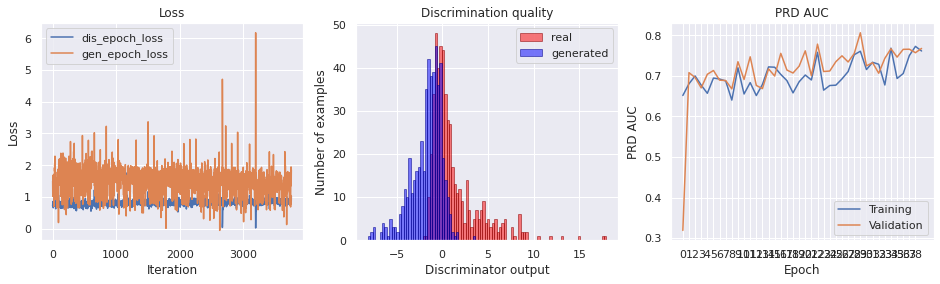

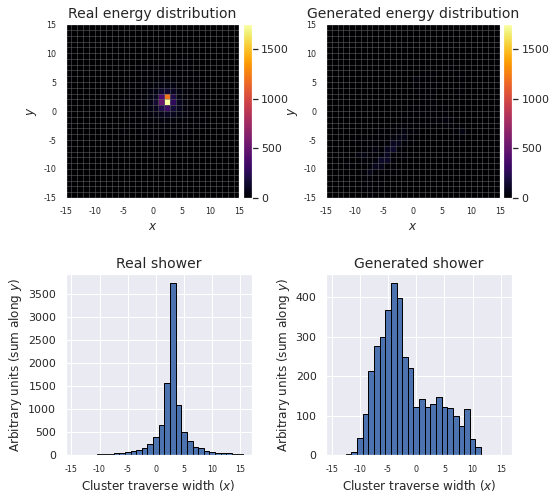



100%|██████████| 40/40 [3:43:37<00:00, 335.44s/it]


In [0]:
import pickle

path = '/gdrive/My Drive/'
filename = 'model_sa_60_full.pt'
filename2 = 'model_sa_100_full.pt'
for i in range(1):
    new_tr_class = None

    # load training class
    with open(path + filename, 'rb') as pickle_file:
        new_tr_class = pickle.load(pickle_file)

    new_tr_class.run(40, True)

    with open(path + filename2, 'wb') as pickle_file:
        pickle.dump(new_tr_class, pickle_file)
    
    del new_tr_class;

In [0]:
import pickle

path = '/gdrive/My Drive/'
filename = 'model_sa_100_full.pt'
filename2 = 'model_sa_140_full.pt'
for i in range(1):
    new_tr_class = None

    # load training class
    with open(path + filename, 'rb') as pickle_file:
        new_tr_class = pickle.load(pickle_file)

    new_tr_class.run(40, True)

    with open(path + filename2, 'wb') as pickle_file:
        pickle.dump(new_tr_class, pickle_file)
    
    del new_tr_class;

  0%|          | 0/40 [00:00<?, ?it/s]

RuntimeError: ignored

In [0]:
with open(path + filename2, 'wb') as pickle_file:
    pickle.dump(model.generator, pickle_file)


In [0]:
import pickle

path = '/gdrive/My Drive/'
filename = 'model_60e_cg_strconv_full.pt'
filename2 = 'model_70e_cg_strconv_full.pt'

for i in range(1):
    new_tr_class = None

    # load training class
    with open(path + filename, 'rb') as pickle_file:
        new_tr_class = pickle.load(pickle_file)

    new_tr_class.run(10, True)

    with open(path + filename2, 'wb') as pickle_file:
        pickle.dump(new_tr_class, pickle_file)
    
    del new_tr_class;

In [0]:
A + torch.tensor([1e-3], dtype=torch.float64)

In [0]:
a = b


#### Transfer generator on CPU:

In [0]:
 # save the last model
#best_generator = generator

# save the best model
best_generator = best_models[1]

generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
generator_cpu.load_state_dict(best_generator.state_dict())
generator_cpu.eval()

# Save the trained model on google disk
#torch.save(generator_cpu.state_dict(), '/gdrive/My Drive/mlhep2019_gan/gan.pt')
#print('The model is saved to', '/gdrive/My Drive/mlhep2019_gan/gan.pt')
torch.save(generator_cpu.state_dict(), '/gdrive/My Drive/gan.pt')

## Making predictions

In [0]:
def model_prediction(input_file, output_file, generator_cpu, batch_size=1024, shuffle=False):
    """
    Model test/validation

        Parameters
        ----------
            input_file : str
                Input file name with path (e.g. data/data_val.npz).
            
            output_file : str
                Output file name with path (e.g. output/data_val_prediction.npz).
            
            generator_cpu :

            
            batch_size : int, optional
                Number of elements in a dataloader batch.
            
            shuffle : bool, optional
                If to enable shuffling in batches.

        Returns:
        ----------
            None
    """
    
    dataset = np.load(input_file, allow_pickle=True)
    val_data_path_out = output_file

    part_mom_val   = torch.tensor(dataset['ParticleMomentum']).float()
    part_point_val = torch.tensor(dataset['ParticlePoint'][:, :2]).float()
    part_mom_point = torch.cat([part_mom_val, part_point_val], dim=1)
    
    calo_dataset    = utils.TensorDataset(part_mom_point)
    calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=batch_size, shuffle=shuffle)

    with torch.no_grad():
        EnergyDeposit_val = []

        for part_mom_point_batch in tqdm(calo_dataloader):
            noise = torch.randn(len(part_mom_point_batch[0]), NOISE_DIM)
            EnergyDeposit_val_batch = generator_cpu(noise, part_mom_point_batch[0]).detach().numpy()
            EnergyDeposit_val.append(EnergyDeposit_val_batch)
        
        np.savez_compressed(output_file, 
                            EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

        del EnergyDeposit_val
    del dataset; del part_mom_val; del part_point_val; del part_mom_point;
    del calo_dataset; calo_dataloader
    return

In [0]:
# (the results are saved to gdrive)

'''
# Validation
model_prediction(def_colab_path + 'data/data_val.npz' , 
                 def_colab_path + 'output/data_val_prediction.npz', 
                 generator_cpu)
# Test
model_prediction(def_colab_path + 'data/data_test.npz', 
                 def_colab_path + 'output/data_test_prediction.npz', 
                 generator_cpu)
'''
# !zip solution.zip data_val_prediction.npz data_test_prediction.npz
# from IPython.display import FileLink
# FileLink('./solution.zip')

In [0]:
def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name, fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.show()
    return

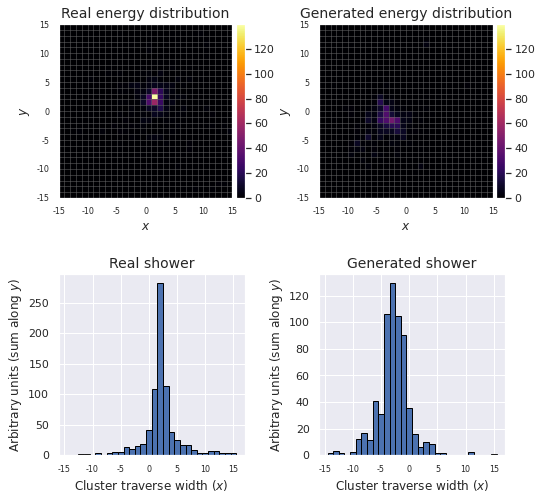

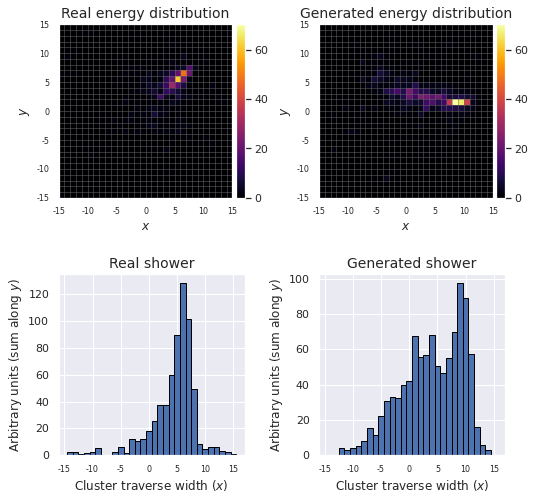

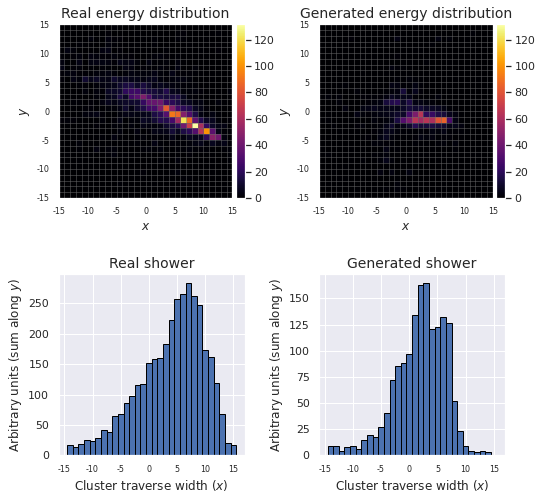

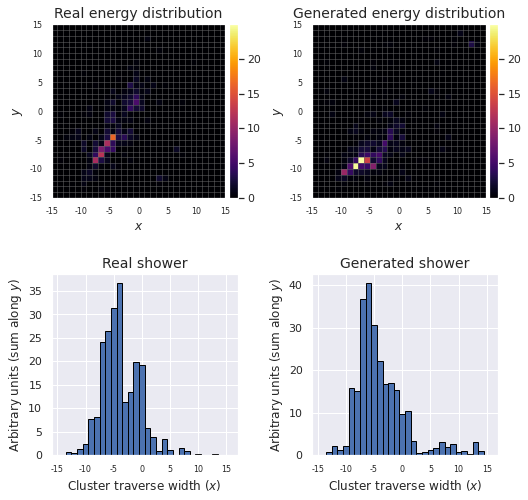

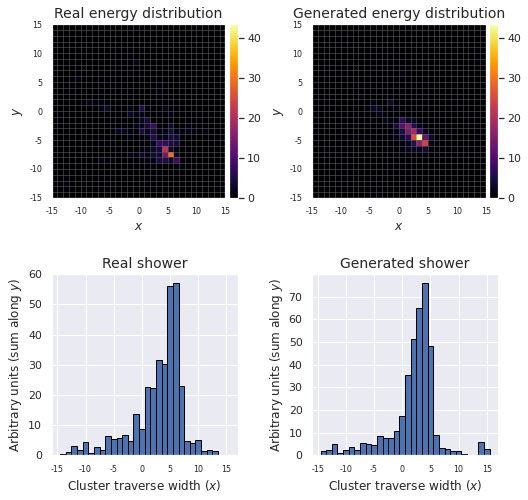

In [0]:
import pickle


filename = 'model_sa_100_full.pt'
with open('/gdrive/My Drive/' + filename, 'rb') as pickle_file:
    new_tr_class = pickle.load(pickle_file)

new_tr_class.generator.eval()

for energy_b, mom_b, point_b, pdg_b in new_tr_class.valid_dataloader:
                
    energy_b, mom_b = energy_b.to(device), mom_b.to(device)
    point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
    mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

    noise = torch.randn(len(energy_b), NOISE_DIM).to(device)
    energy_gen = new_tr_class.generator(noise, mom_point_b)

    plot_energy_and_shower(energy_b.detach().cpu()[0], energy_gen.detach().cpu()[0])

#VAEGAN

In [0]:
class GANLosses(object):
    def __init__(self, task, device, gp = 'local-two-sided'):
        self.TASK = task
        self.device = device
        self.GP = gp
    
    def g_loss(self,  discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output_gen + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output_gen + eps).mean()
        elif self.TASK in ['WASSERSTEIN', 'HINGE']:
            loss = - discrim_output_gen.mean()
        elif self.TASK == 'RAHINGE':
            loss = ((torch.nn.ReLU()(1.0 + (discrim_output_real - torch.mean(discrim_output_gen)))).mean() + (torch.nn.ReLU()(1.0 - (discrim_output_gen - torch.mean(discrim_output_real)))).mean())/2
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        elif self.TASK == 'HINGE':
            loss = torch.nn.ReLU()(1.0 - discrim_output_real).mean() + torch.nn.ReLU()(1.0 + discrim_output_gen).mean()
        elif self.TASK == 'RAHINGE':
            loss = (torch.mean(torch.nn.ReLU()(1.0 - (discrim_output_real - torch.mean(discrim_output_gen)))) + torch.mean(torch.nn.ReLU()(1.0 + (discrim_output_gen - torch.mean(discrim_output_real)))))/2
        return loss

    def calc_gradient_penalty(self, discriminator, img, data_gen, inputs_batch, inp_data, lambda_reg = .5):
        gradient_penalty = 0
        k = 1

        if self.GP == 'local-two-sided':
            N = 0.01

            noise_y = torch.normal(0, N, size=inp_data.shape).to(self.device)

            perturbed_y = (inp_data + noise_y).to(self.device)

            perturbed_y.requires_grad = True

            disc_interpolates = discriminator(img, perturbed_y, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=perturbed_y,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((l2_norm(gradients) - k) ** 2).mean() * lambda_reg

        elif self.GP == 'original':
            alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
            dims_to_add = len(inp_data.size()) - 2
            for i in range(dims_to_add):
                alpha = alpha.unsqueeze(-1)
                # alpha = alpha.expand(inp_data.size())

            interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

            interpolates.requires_grad = True

            disc_interpolates = discriminator(img, interpolates, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, img, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(img, local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

In [0]:
from torch.nn.utils import spectral_norm

class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        
        # 30x30x1
        #self.attn0 = SelfAttention(1, 'relu')
        self.conv1 = spectral_norm(nn.Conv2d( 1,   32, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x32
        self.conv2 = spectral_norm(nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x64       
        self.pool1 = nn.AvgPool2d(2, 2)                                         # 15x15x64
        self.conv_inn = spectral_norm(nn.Conv2d( 64,  1, kernel_size=(3,3), stride=(1,1), padding=(1,1)))

        self.conv3 = spectral_norm(nn.Conv2d( 64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x128
        self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1))) # 5x5x256
        
        #self.pool2 = nn.MaxPool2d(3, 3)                                                  # 15x15x256
        #self.conv6 = spectral_norm(nn.Conv2d(256, 256, kernel_size=(3,3), stride=(3,3), padding=(1,1)))
        #self.attn2 = SelfAttention(256, 'relu')
        
        # 5x5x256 = 6400
        self.fc1 = spectral_norm(nn.Linear(6405, 1024))
        #self.fc2 = spectral_norm(nn.Linear(1024,32))
        #self.cl = spectral_norm(nn.Linear(5, 1024)) #cgan projection, in original paper: res_block + global_max_pool + linear
        self.fc3 = spectral_norm(nn.Linear(1024,1))
        
    def forward(self, z, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = EnergyDeposit
        X = F.leaky_relu(self.conv1(X))
        X = F.leaky_relu(self.conv2(X))
        inp = self.conv_inn(X)
        #X, _ = self.attn1(X)
        X = self.pool1(X)

        X = F.leaky_relu(self.conv3(X))
        X = F.leaky_relu(self.conv4(X))
        #X = F.leaky_relu(self.conv5(X))
        #X = F.leaky_relu(self.conv6(X))
        #X, _ = self.attn2(X)
        #X = self.pool2(X)
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        X = torch.cat([X, mom_point], dim=1)
        X = F.leaky_relu(self.fc1(X))
        #X = F.leaky_relu(self.fc2(X))
        #X = F.leaky_relu(self.fcbn1(self.fc1(X)))
        #X = F.leaky_relu(self.fcbn2(self.fc2(X)))
        #X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK in ['WASSERSTEIN', 'HINGE', 'RAHINGE']:
            return self.fc3(X) + torch.sum(z * inp, dim=[1, 2, 3], keepdim=True)
        else:
            return torch.sigmoid(self.fc1(X))

In [0]:
NOISE_DIM = 10

class ModelG(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelG, self).__init__()

        self.conv1 = spectral_norm(nn.Conv2d( 1,   64, kernel_size=(3,3), stride=(1,1), padding=(1,1)))
        self.bn1 = ConditionalBatchNorm2d(5, 64)
        self.conv2 = spectral_norm(nn.Conv2d( 64,   128, kernel_size=(3,3), stride=(1,1), padding=(1,1)))
        self.bn2 = nn.BatchNorm2d(128)
        #self.attn1 = SelfAttention(128, 'relu')
        self.conv3 = spectral_norm(nn.Conv2d( 128,   64, kernel_size=(3,3), stride=(1,1), padding=(1,1)))
        self.bn3 = ConditionalBatchNorm2d(5, 64)
        self.conv4 = spectral_norm(nn.Conv2d( 64,   1, kernel_size=(3,3), stride=(1,1), padding=(1,1)))

        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        mom_point = (ParticleMomentum_ParticlePoint - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        
        #print(EnergyDeposit.shape)
        EnergyDeposit = F.leaky_relu(self.bn1(self.conv1(z), mom_point))
        #EnergyDeposit = F.relu(self.bn1(self.conv1(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        #EnergyDeposit, _ = self.attn1(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit), mom_point))
        #EnergyDeposit, _ = self.attn2(EnergyDeposit)
        EnergyDeposit = F.relu(self.conv4(EnergyDeposit))

        return EnergyDeposit

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def prd_auc(generated_example, real_example, reshape_size):
    precision, recall = compute_prd_from_embedding(
                            generated_example.reshape(reshape_size, -1), 
                            real_example.reshape(reshape_size, -1),
                            num_clusters=30, num_runs=100)
    return auc(precision, recall)

NOISE_DIM = 10

class TrainingProcedure:

    def __init__(self, loss_function_type, discriminator, generator, vae_pretrained,
                 train_dataloader, valid_dataloader,
                 batch_size, valid_size,
                 lr_dis = 4e-4, lr_gen = 1e-4,
                 dis_iter_num = 3, gen_iter_num = 1, noise_dim = NOISE_DIM):

        self.current_epoch = 0
        self.gan_losses = GANLosses(TASK, device)
        self.discriminator = discriminator.to(device)
        self.generator = generator.to(device)
        self.VAE = vae_pretrained.to(device)

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.BATCH_SIZE = batch_size
        self.VALID_SIZE = valid_size
        self.noise_dim  = noise_dim

        # array for saving the distributions that are generated on every step
        self.DRAW_ID = 8
        energy, _, _, _ = self.valid_dataloader.dataset[self.DRAW_ID]
        self.generated_examples_list = [energy] # first element is the real distribution

        self.best_models = [self.discriminator, self.generator]

        self.g_optimizer = optim.Adam(self.generator.parameters(), betas=(0.0, 0.999), lr=lr_gen)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), betas=(0.0, 0.999), lr=lr_dis)

        self.k_d = dis_iter_num
        self.k_g = gen_iter_num
        
        self.dis_epoch_loss,  self.gen_epoch_loss  = [], []
        self.predictions_dis, self.predictions_gen = [], []
        self.prd_auc = []  

        self.val_prd_auc = []

        return

    def run(self, epoch_num, use_separate_validation=False):
        for epoch in tqdm(np.arange(self.current_epoch, epoch_num)):      
            # Validation
            if use_separate_validation:
                self.validation()        
            
            # Training
            self.generator.train()
            self.discriminator.train()
            first = True

            for energy_b, mom_b, point_b, pdg_b in self.train_dataloader:
                
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

                if first:
                    noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                    vae_energy_b = self.VAE.decode(noise, mom_point_b)
                    energy_gen = self.generator(vae_energy_b, mom_point_b)
                    
                    pred_dis_list = list(self.discriminator(vae_energy_b, energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                    pred_gen_list = list(self.discriminator(vae_energy_b, energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                    
                    self.predictions_dis.append(pred_dis_list)
                    self.predictions_gen.append(pred_gen_list)
                    
                # Optimize D
                dis_loss_item = self.train_epoch_dis(self.k_d, energy_b, mom_point_b)
                self.dis_epoch_loss.append(dis_loss_item)

                # Optimize G
                gen_loss_item = self.train_epoch_gen(self.k_g, energy_b, mom_point_b)
                self.gen_epoch_loss.append(gen_loss_item)

                if first:
                    reshape_size = pdg_b.shape[0] # = BATCH_SIZE or less
                    self.prd_auc.append(prd_auc(energy_gen.detach().cpu().numpy(),
                                                energy_b  .detach().cpu().numpy(), 
                                                reshape_size))
                    first = False
            
            # Save the new model if it is the best one (max training prd)
            if self.prd_auc[-1] == np.max(self.prd_auc):
                print("New best model")
                self.best_models = [self.discriminator, self.generator]

            # Plot training progress

            self.generator.eval()
            self.discriminator.eval()

            with torch.no_grad():
                energy_b, mom_b, point_b, pdg_b = self.valid_dataloader.dataset[self.DRAW_ID]

                energy_b = energy_b.reshape((1,1,30,30))
                point_b  = point_b.reshape((1,2))
                mom_b    = mom_b.reshape((1,3))
                pdg_b    = pdg_b.reshape((1,1))

                noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                vae_energy_b = self.VAE.decode(noise, mom_point_b)

                energy_gen = self.generator(vae_energy_b, mom_point_b)
                real_res = energy_b  .detach().cpu()[0]
                gen_res  = energy_gen.detach().cpu()[0]

                self.generated_examples_list.append(gen_res) # save the generated example

                if not use_separate_validation:
                    self.val_prd_auc = self.prd_auc # заглушка, чтобы сильно не менять функцию построения графиков

                self.plot_training_progress(epoch, real_res, gen_res)

            self.current_epoch += 1  

        return

    def train_epoch_dis(self, k_d, energy_b, mom_point_b):
        """
        Train discriminator for one epoch
        
            Parameters
            ----------
                k_d : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_d):
            noise = torch.randn(len(energy_b), self.noise_dim).to(device)
            vae_energy_b = self.VAE.decode(noise, mom_point_b)

            energy_gen = self.generator(vae_energy_b, mom_point_b)

            if INSTANCE_NOISE:
                energy_b   = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
                
            loss = self.gan_losses.d_loss(self.discriminator(vae_energy_b, energy_gen, mom_point_b),
                                          self.discriminator(vae_energy_b, energy_b,   mom_point_b))
        
            coef = 0
            if GRAD_PENALTY:
                coef = +1.
            elif ZERO_CENTERED_GRAD_PENALTY:
                coef = -1.

            loss += coef * self.gan_losses.calc_gradient_penalty(self.discriminator, vae_energy_b,
                                                            energy_gen.data,
                                                            mom_point_b,
                                                            energy_b.data)
            self.d_optimizer.zero_grad()
            loss.backward()
            self.d_optimizer.step()

            if LIPSITZ_WEIGHTS:                    
                [p.data.clamp_(clamp_lower, clamp_upper) for p in self.discriminator.parameters()]

        return loss.item()


    def train_epoch_gen(self, k_g, energy_b, mom_point_b):
        """
        Train generator for one epoch
        
            Parameters
            ----------
                k_g : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_g):
            noise = torch.randn(len(energy_b), self.noise_dim).to(device)
            vae_energy_b = self.VAE.decode(noise, mom_point_b)
            energy_gen = self.generator(vae_energy_b, mom_point_b)

            if INSTANCE_NOISE:
                energy_b = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
            
            loss = self.gan_losses.g_loss(self.discriminator(vae_energy_b, energy_gen, mom_point_b))
            
            self.g_optimizer.zero_grad()
            loss.backward()
            self.g_optimizer.step()

        return loss.item()

    def validation(self):
        self.generator.eval()
        self.discriminator.eval()

        with torch.no_grad():

            #val_predictions_dis, val_predictions_gen = [], []
            val_energy_b, val_energy_gen  = [], []

            for energy_b, mom_b, point_b, pdg_b in self.valid_dataloader:
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                vae_energy_b = self.VAE.decode(noise, mom_point_b)

                energy_gen = self.generator(vae_energy_b, mom_point_b)
                
                val_energy_b.append(energy_b.detach().cpu().numpy())
                val_energy_gen.append(energy_gen.detach().cpu().numpy())

                #pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                #pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                
                #val_predictions_dis.append(pred_dis_list)
                #val_predictions_gen.append(pred_gen_list)

            val_energy_gen = np.concatenate(val_energy_gen, axis=0)
            val_energy_b   = np.concatenate(val_energy_b,   axis=0)

            self.val_prd_auc.append(prd_auc(val_energy_gen, val_energy_b, 
                                            self.VALID_SIZE))
        return

    def plot_training_progress(self, epoch, example_real, example_gen):
        """
        Plot training curves (loss, discrimination quality, prd-auc) and draw
        real/generated energy distributions and showers.
        
            Parameters
            ----------
                epoch : int
                    Current epoch number.
                
                example_real : torch.Tensor 30x30x1
                    Random energy distribution from the training dataset.
                
                example_gen : torch.Tensor
                    Generated energy distribution for the emaple from the 
                    training dataset. Real distribution is passed in example_real.
        """

        clear_output()

        print('Epoch #%d\nMean discriminator output on real data = %g\n'\
              'Mean discriminator output on generated data = %g' % 
              (epoch, np.mean(self.predictions_dis[-1]), np.mean(self.predictions_gen[-1])))
        
        fs_title = 14
        fs_axis = 12
        fs_ticks = 10

        f, ax = plt.subplots(1,3, figsize=(20, 5))
        ax[0].set_title ('Training loss', fontsize=fs_title)
        ax[0].set_xlabel('Epoch',     fontsize=fs_axis)
        ax[0].set_ylabel('Loss',          fontsize=fs_axis)

        ax[0].set_xticks     (np.linspace(0.0, len(self.dis_epoch_loss), 5))
        ax[0].set_xticklabels(np.linspace(0.0, epoch, 5))
        ax[0].plot(self.dis_epoch_loss, label='discriminator', color = 'red',  alpha=0.5)
        ax[0].plot(self.gen_epoch_loss, label='generator',     color = 'blue', alpha=0.5)
        ax[0].legend()

        ax[1].set_title ('Discrimination quality', fontsize=fs_title)
        ax[1].set_xlabel('Discriminator output',   fontsize=fs_axis)
        ax[1].set_ylabel('Number of examples',     fontsize=fs_axis)
        # get the bin edges to get an equal bin size for both distributions
        bins = np.histogram(np.hstack((self.predictions_dis[-1],
                                    self.predictions_gen[-1])), bins=100)[1]
        ax[1].hist(self.predictions_dis[-1], bins, label='real',      color = 'red',  ec='darkred',  alpha=0.5)
        ax[1].hist(self.predictions_gen[-1], bins, label='generated', color = 'blue', ec='darkblue', alpha=0.5)
        ax[1].legend()

        ax[2].set_xticks     (np.linspace(0.0, epoch, 5))
        ax[2].set_xticklabels(np.linspace(0.0, epoch, 5))
        ax[2].set_title ('PRD AUC', fontsize=fs_title)
        ax[2].set_xlabel('Epoch',   fontsize=fs_axis)
        ax[2].set_ylabel('PRD AUC', fontsize=fs_axis)
        #ax[2].set_xticks(np.arange(0,epoch))
        ax[2].plot(self.prd_auc,     label="Training",  color='red')
        ax[2].plot(self.val_prd_auc, label="Validaion", color='blue')
        ax[2].legend()

        #plot_energy_distr_real_generated(example_real, example_gen)
        #plot_shower_real_generated(example_real, example_gen) 
        plot_energy_and_shower(example_real, example_gen)
        plt.show()
        
        return

In [0]:
def train_model(epoch_num, particle_type_id, discriminator, generator, vae_pretrained,
                train_size = 16000, valid_size = -1, valid_ratio = 0.05, 
                batch_size = 512, dis_iter_num = 4, gen_iter_num = 1, 
                noise_dim = 30, if_normalise_energies=False, if_rotate_dataset=False,
                loss_type='HINGE'):
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    
    if valid_size < 0:
        valid_size = int(valid_ratio * train_size)

    if_one_particle_transf = True
    
    if particle_type_id < 0:
        if_one_particle_transf = False

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, train_size, valid_size,
                                                      one_particle_transf=if_one_particle_transf, 
                                                      particle_id=particle_type_id,
                                                      rotate_transf=if_rotate_dataset, 
                                                      normalise_energies=if_normalise_energies)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', particle_type_id)
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    #energy_b, mom_b, point_b, pdg_b = valid_dataloader.dataset[8]
    #energy_b = energy_b.reshape((1,1,30,30))
    #plot_energy_and_shower(energy_b, energy_b)

    training = TrainingProcedure(loss_type, discriminator, generator, vae_pretrained,
                                 train_dataloader, valid_dataloader, 
                                 batch_size, res_valid_size,
                                 dis_iter_num=dis_iter_num, gen_iter_num=gen_iter_num, noise_dim = noise_dim)
    training.run(epoch_num, True)
    return training, training.best_models

def save_generator(generator, filename, noise_dim=NOISE_DIM):
    generator_cpu = FccGanGenerator(z_dim=noise_dim)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

In [0]:
class VAE(nn.Module):
	def __init__(self, h_dim=128, z_dim=30):
		super(VAE, self).__init__()
	
		self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.pool1 = nn.MaxPool2d(2) #15x15
		self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)) #7x7
		self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv6 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  
		self.bn1 = nn.BatchNorm2d(16)
		self.bn2 = nn.BatchNorm2d(32)
		self.bn3 = nn.BatchNorm2d(32)
		self.bn4 = nn.BatchNorm2d(64)
		self.bn5 = nn.BatchNorm2d(64)
		self.bn6 = nn.BatchNorm2d(128)
	
		self.fc1 = nn.Linear(h_dim + 5, z_dim)
		self.fc2 = nn.Linear(h_dim + 5, z_dim)
		self.fc3 = nn.Linear(z_dim + 5, h_dim)
		self.fc4 = nn.Linear(h_dim, 512)
		self.fc5 = nn.Linear(512, 3200)

		self.conv1t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv2t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv3t = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3))
		self.conv4t = nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
		self.conv5t = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3))
		self.conv6t = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3))
		self.conv7t = nn.ConvTranspose2d(16, 1, kernel_size=(3, 3))
	
		self.bn1t = nn.BatchNorm2d(128)
		self.bn2t = nn.BatchNorm2d(128)
		self.bn3t = nn.BatchNorm2d(64)
		self.bn4t = nn.BatchNorm2d(64)
		self.bn5t = nn.BatchNorm2d(32)
		self.bn6t = nn.BatchNorm2d(16)

	def encode(self, x, params):
		#print(x.shape)
		x = F.leaky_relu(self.bn1(self.conv1(x))) # 30x30
		x = F.leaky_relu(self.bn2(self.conv2(x)))
		x = self.bn3(self.conv3(x))
		x = F.leaky_relu(self.pool1(x)) 			# 15x15
		x = F.leaky_relu(self.bn4(self.conv4(x)))  
		x = F.leaky_relu(self.bn5(self.conv5(x)))  
		x = self.bn6(self.conv6(x)) 				# 7x7
	
		x = F.leaky_relu(nn.MaxPool2d(kernel_size=x.size()[2:])(x))
		x = x.view(x.size(0), -1)
		x = F.leaky_relu(x)
		x = torch.cat([x, params], dim=1)
		return F.leaky_relu(self.fc1(x)), F.leaky_relu(self.fc2(x))


	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std


	def decode(self, z, params):
		z = F.leaky_relu(self.fc3(torch.cat([z, params], dim=1)))
		z = F.leaky_relu(self.fc4(z))
		z = F.leaky_relu(self.fc5(z))
		z = z.view(-1, 128, 5, 5)			# 5x5x128
		z = F.leaky_relu(self.bn1t(self.conv1t(z)))  	# 7x7x128
		z = F.leaky_relu(self.bn2t(self.conv2t(z)))	# 9x9x128
		z = F.leaky_relu(self.bn3t(self.conv3t(z)))	# 11x11x64
		z = F.leaky_relu(self.bn4t(self.conv4t(z)))	# 24x24x64
		z = F.leaky_relu(self.bn5t(self.conv5t(z)))	# 26x26x32
		z = F.leaky_relu(self.bn6t(self.conv6t(z)))	# 28x28x16
		z = F.leaky_relu(self.conv7t(z))					# 30x30x1
		
		return z


	def forward(self, x, params):
		mu, logvar = self.encode(x, params)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, params), mu, logvar

In [0]:
import pickle

path = '/gdrive/My Drive/'
filename = 'vae8.pt'
filename2 = 'model_sa_70.pt'

vae8 = VAE().to(device)
vae8.load_state_dict(torch.load(path + '/vae8.pt'))

vae8.eval()

model, b_model = train_model(60, 11., train_size = 20000,
                                       discriminator = ModelD(), 
                                       generator = ModelG(z_dim=10), vae_pretrained = vae8,
                                       dis_iter_num=4, gen_iter_num=1)


In [0]:
def test(epoch):
  model.eval()
  test_loss = 0
  kl_loss = 0
  rmse_loss = 0
  for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader_test:
    EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                          ParticleMomentum_b.to(device), \
                                                          ParticlePoint_b.to(device)
    ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
    data = EnergyDeposit_b
    recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
    loss, rmse, kl = loss_function(recon_batch, EnergyDeposit_b, mu, logvar)
    if epoch == 0:
        plt.figure(figsize=(12, 12))
        plt.title('Test')
        ax = plt.subplot(211)
        ax.set_title("Real TEST")
        plt.imshow(EnergyDeposit_b[0].detach().cpu().numpy().reshape(30, 30))
        ax = plt.subplot(212)
        ax.set_title("Generated TEST")
        plt.imshow(recon_batch[0].detach().cpu().numpy().reshape(30, 30))
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        plt.colorbar(cax=cax)
        plt.show()
        plot_energy_and_shower(EnergyDeposit_b[0].detach().cpu(), recon_batch[0].detach().cpu())
    test_loss += loss.item()
    kl_loss += kl
    rmse_loss += rmse
  print('TEST ====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, test_loss / len(calo_dataloader_test.dataset)), 'RMSE:', rmse_loss / len(calo_dataloader_test.dataset), 'KL:', kl_loss / len(calo_dataloader_test.dataset))